

# Reporte de problemas fitosanitarios en plantaciones de agave
--------------------

## Equipo 36

| Nombre | Matrícula |
| ------ | --------- |
| André Martins Cordebello | A00572928 |
| Enrique Eduardo Solís Da Costa | A00572678 |
| Delbert Francisco Custodio Vargas | A01795613 |

## Avance 3: baseline

Este avance consiste en construir un modelo de referencia que permita evaluar la viabilidad del problema. Si el baseline tiene un rendimiento similar al azar, podría indicar que el problema es intrínsecamente difícil o que los datos no contienen suficiente información para predecir el objetivo. De lo contrario, el baseline podría como una solución mínima aceptable cuando se trabaja en escenarios donde incluso un modelo simple puede proporcionar valor.

Un baseline facilita también la gestión de expectativas, tanto dentro del equipo como con los stakeholders, pues proporciona una comprensión inicial de lo que se puede lograr con métodos simples antes de invertir tiempo y recursos en enfoques más complejos.

Se empieza con la carga del archivo con el cual se estará trabajando.

In [23]:
import pandas as pd
df = pd.read_excel('baseline.xlsx')
df.head()

,Unnamed: 0,tramp_id,sampling_date,lat,lon,municipality,square_area,plantation_age,capture_count,state,...,month_cos,critical_season,severity_encoded,distance_to_nearest_hotspot,hotspots_within_5km,text_feature_location,text_feature_risk,text_feature_capture,text_feature_plantation,text_feature_all_things
0,0,167_THUE13-16-104-0009T13,2014-01-01,20.01578,-102.57259,VILLAMAR,0.33,0,0.0,MICHOACAN,...,0.866025,0,0,62.301408,0,La trampa con identificacion 167_THUE13-16-104...,La trampa con identificacion 167_THUE13-16-104...,Durante la temporada normal el dia 1 del mes E...,En una plantacion de agave azul con area de 0....,En una plantacion de agave azul con area de 0....
1,1,167_THUE13-16-104-0009T15,2014-01-01,20.01428,-102.57326,VILLAMAR,0.34,0,0.0,MICHOACAN,...,0.866025,0,0,62.483803,0,La trampa con identificacion 167_THUE13-16-104...,La trampa con identificacion 167_THUE13-16-104...,Durante la temporada normal el dia 1 del mes E...,En una plantacion de agave azul con area de 0....,En una plantacion de agave azul con area de 0....
2,2,167_THUE13-16-104-0009T25,2014-01-01,20.01524,-102.57386,VILLAMAR,0.33,0,0.0,MICHOACAN,...,0.866025,0,0,62.407969,0,La trampa con identificacion 167_THUE13-16-104...,La trampa con identificacion 167_THUE13-16-104...,Durante la temporada normal el dia 1 del mes E...,En una plantacion de agave azul con area de 0....,En una plantacion de agave azul con area de 0....
3,3,167_THUE13-16-104-0009T10,2014-01-01,20.01723,-102.57218,VILLAMAR,0.33,0,0.0,MICHOACAN,...,0.866025,0,0,62.134520,0,La trampa con identificacion 167_THUE13-16-104...,La trampa con identificacion 167_THUE13-16-104...,Durante la temporada normal el dia 1 del mes E...,En una plantacion de agave azul con area de 0....,En una plantacion de agave azul con area de 0....
4,4,167_THUE13-16-104-0009T28,2014-01-01,20.01699,-102.57360,VILLAMAR,0.33,0,0.0,MICHOACAN,...,0.866025,0,0,62.215955,0,La trampa con identificacion 167_THUE13-16-104...,La trampa con identificacion 167_THUE13-16-104...,Durante la temporada normal el dia 1 del mes E...,En una plantacion de agave azul con area de 0....,En una plantacion de agave azul con area de 0....


Para lograr realizar un estudio de manera rápida y concisa, se estará trabajando únicamente con los datos obtenidos en los años 2023 a 2025 para reducir tiempos de entrenamiento y poder probar con más modelos en menos tiempo. Además, se eliminan columnas de texto que se utilizarán para entrenar el LLM del chatbot que se desarrollará, pero que no son de importancia para este estudio.

In [24]:
# ===============================
# Filtrar dataset (2023-2025) y eliminar columnas no necesarias
# ===============================

# Filtrar solo los años 2023, 2024 y 2025
df = df[df['year'].between(2023, 2025)]

# Verificar los valores únicos en la columna 'year'
print("Años disponibles en el dataset:", df['year'].unique())

# Eliminar columnas de texto irrelevantes
cols_to_drop = [
    'text_feature_location',
    'text_feature_risk',
    'text_feature_capture',
    'text_feature_plantation',
    'text_feature_all_things'
]

# Verificar si existen antes de eliminarlas
cols_present = [col for col in cols_to_drop if col in df.columns]
df = df.drop(columns=cols_present)

print(f"Columnas eliminadas: {cols_present}")
print("Dimensiones finales del dataset:", df.shape)

# (Opcional) Guardar el dataset filtrado en un nuevo archivo
df.to_excel("baseline_filt_23_25.xlsx", index=False)
print("Archivo guardado como baseline_filt_23_25.xlsx")


Años disponibles en el dataset: [2023 2024 2025]
Columnas eliminadas: ['text_feature_location', 'text_feature_risk', 'text_feature_capture', 'text_feature_plantation', 'text_feature_all_things']
Dimensiones finales del dataset: (171683, 26)
Archivo guardado como baseline_filt_23_25.xlsx


Se vuelve a hacer un análisis de las variables categoricas para determinar si son relevantes para el estudio y si necesitan algún tipo de encoder.

In [25]:
# ===============================
# Análisis inicial del dataset filtrado (2023-2025)
# ===============================

import pandas as pd

# Cargar el archivo filtrado
df = pd.read_excel("baseline_filt_23_25.xlsx")

# Mostrar información general
print("Dimensiones del dataset:", df.shape)
print("\nColumnas del dataset:")
print(df.columns.tolist())

# Tipos de datos y conteo de valores nulos
print("\nResumen de tipos de datos y valores nulos:")
print(df.info())
print("\nValores nulos por columna:")
print(df.isnull().sum())

# Verificar si hay variables categóricas
print("\nVariables categóricas detectadas:")
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print(cat_cols if len(cat_cols) > 0 else "No se detectaron variables categóricas")

# Mostrar ejemplo de los primeros registros
print("\nPrimeras filas del dataset:")
display(df.head())

Dimensiones del dataset: (171683, 26)

Columnas del dataset:
['Unnamed: 0', 'tramp_id', 'sampling_date', 'lat', 'lon', 'municipality', 'square_area', 'plantation_age', 'capture_count', 'state', 'square_area_imputed', 'month', 'year', 'year_month', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week_sin', 'day_of_week_cos', 'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos', 'critical_season', 'severity_encoded', 'distance_to_nearest_hotspot', 'hotspots_within_5km']

Resumen de tipos de datos y valores nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171683 entries, 0 to 171682
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Unnamed: 0                   171683 non-null  int64         
 1   tramp_id                     171683 non-null  object        
 2   sampling_date                171683 non-null  datetime64[ns]
 3   lat                        

,Unnamed: 0,tramp_id,sampling_date,lat,lon,municipality,square_area,plantation_age,capture_count,state,...,day_of_week_sin,day_of_week_cos,week_of_year_sin,week_of_year_cos,month_sin,month_cos,critical_season,severity_encoded,distance_to_nearest_hotspot,hotspots_within_5km
0,656173,162_THUE13-16-074-0027T01,2023-01-01,20.096520,-102.814320,COJUMATLAN DE REGULES,1.0,0,0.0,MICHOACAN,...,-0.781831,0.62349,-2.449294e-16,1.0,0.5,0.866025,0,0,9999.0,0
1,656174,162_THUE13-16-074-0007T01,2023-01-01,20.147118,-102.896716,COJUMATLAN DE REGULES,1.0,0,0.0,MICHOACAN,...,-0.781831,0.62349,-2.449294e-16,1.0,0.5,0.866025,0,0,9999.0,0
2,656175,162_THUE13-16-074-0013T01,2023-01-01,20.142147,-102.882885,COJUMATLAN DE REGULES,2.0,0,0.0,MICHOACAN,...,-0.781831,0.62349,-2.449294e-16,1.0,0.5,0.866025,0,0,9999.0,0
3,656176,162_THUE13-16-074-0012T01,2023-01-01,20.144013,-102.882413,COJUMATLAN DE REGULES,2.0,0,0.0,MICHOACAN,...,-0.781831,0.62349,-2.449294e-16,1.0,0.5,0.866025,0,0,9999.0,0
4,656177,162_THUE13-16-074-0024T01,2023-01-01,20.146415,-102.881007,COJUMATLAN DE REGULES,2.0,0,0.0,MICHOACAN,...,-0.781831,0.62349,-2.449294e-16,1.0,0.5,0.866025,0,0,9999.0,0


Se optó por eliminar la columna 'tramp_ID', ya que esta no agrega datos relevantes, así como severity_encoded que es redundante con capture_count, así como codificar las columnas 'municipality' y 'state' y separar la columna 'year_month' para poder obtener únicamente el mes (ya existe una columna con el año del dato).

In [ ]:
# ===============================
# Preparación de variables categóricas
# ===============================

# Eliminar ID de trampa (no es informativo para el efecto de este modelo)
if 'tramp_id' in df.columns:
    df = df.drop(columns=['tramp_id'])

#Eliminar severity_encoded (parece redundante con capture_count)
if 'severity_encoded' in df.columns:
    df = df.drop(columns=['severity_encoded'])

# Convertir columna 'year_month' a variables numéricas separadas y eliminar year (ya existente)
if 'year_month' and 'sampling_date' in df.columns:
    df['day'] = df['sampling_date'].dt.day
    df['month'] = df['sampling_date'].dt.month
    df = df.drop(columns=['year_month','sampling_date'])

# Codificar variables categóricas relevantes ('municipality', 'state')
df = pd.get_dummies(df, columns=['municipality', 'state'], drop_first=True)

# Verificar resultado
print("Columnas finales después de la codificación:")
print(df.columns.tolist())

Columnas finales después de la codificación:
['Unnamed: 0', 'lat', 'lon', 'square_area', 'plantation_age', 'capture_count', 'square_area_imputed', 'month', 'year', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week_sin', 'day_of_week_cos', 'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos', 'critical_season', 'distance_to_nearest_hotspot', 'hotspots_within_5km', 'day', 'municipality_ACATIC', 'municipality_ACATLAN DE JUAREZ', 'municipality_AHUACATLAN', 'municipality_AHUALULCO DE MERCADO', 'municipality_AMACUECA', 'municipality_AMATITAN', 'municipality_AMATLAN DE CANAS', 'municipality_AMECA', 'municipality_ARANDAS', 'municipality_ATENGO', 'municipality_ATENGUILLO', 'municipality_ATOTONILCO EL ALTO', 'municipality_ATOYAC', 'municipality_AUTLAN DE NAVARRO', 'municipality_AYOTLAN', 'municipality_AYUTLA', 'municipality_BRISENAS', 'municipality_CANADAS DE OBREGON', 'municipality_CASIMIRO CASTILLO', 'municipality_CHAPALA', 'municipality_CHIQUILISTLAN', 'municipality_CHURINTZIO', 

Se hace la separación de la base de datos en variables dependientes e independientes para que se pueda empezar a crear modelos de predicción.

In [27]:
# Definir variables predictoras y objetivo
X = df.drop(columns=['capture_count'])
y = df['capture_count']

print("\nX shape:", X.shape)
print("y shape:", y.shape)



X shape: (171683, 167)
y shape: (171683,)


Ya que hizo la separación de las variables X y Y, se procede a crear un primer modelo de predicción utilizando Random Forest Regressor. Se optó por utilizar este método por que trabaja bien con datos no lineales, tolera outliers y nos permitirá obtener la importancia de las variables. Se realiza el estudio utilizando los valores default de RandomForestRegressor.

In [ ]:
# ===============================
# Modelo Baseline - Random Forest
# ===============================

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Dividir dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Entrenar modelo baseline
rf = RandomForestRegressor(
    n_estimators=100,       # número de árboles
    max_depth=None,         # sin límite de profundidad
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Predicciones
y_pred = rf.predict(X_test)

# Evaluación
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Evaluación del modelo baseline con Random Forest Regressor:")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")


📊 Evaluación del modelo baseline:
MAE  = 2.8432
RMSE = 5.3918
R²   = 0.4908


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean

🔹 XGBoost (reg:squarederror)
MAE  : 3.136
RMSE : 5.580
R²   : 0.455
Best iteration (early stop): 498


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean


🔹 XGBoost (count:poisson)
MAE  : 3.134
RMSE : 5.636
R²   : 0.444
Best n_estimators (early stop): 799

Top 15 features:
hotspots_within_5km                         0.075826
state_NAYARIT                               0.037307
municipality_EL GRULLO                      0.024916
distance_to_nearest_hotspot                 0.023550
municipality_IXTLAHUACAN DEL RIO            0.021845
state_JALISCO                               0.020987
municipality_VILLAMAR                       0.020902
year                                        0.019723
municipality_JUCHITLAN                      0.016684
municipality_TUXCACUESCO                    0.016171
municipality_YAHUALICA DE GONZALEZ GALLO    0.015818
municipality_ROMITA                         0.015632
municipality_MARAVATIO                      0.015345
municipality_AUTLAN DE NAVARRO              0.014855
municipality_CANADAS DE OBREGON             0.014845
dtype: float32


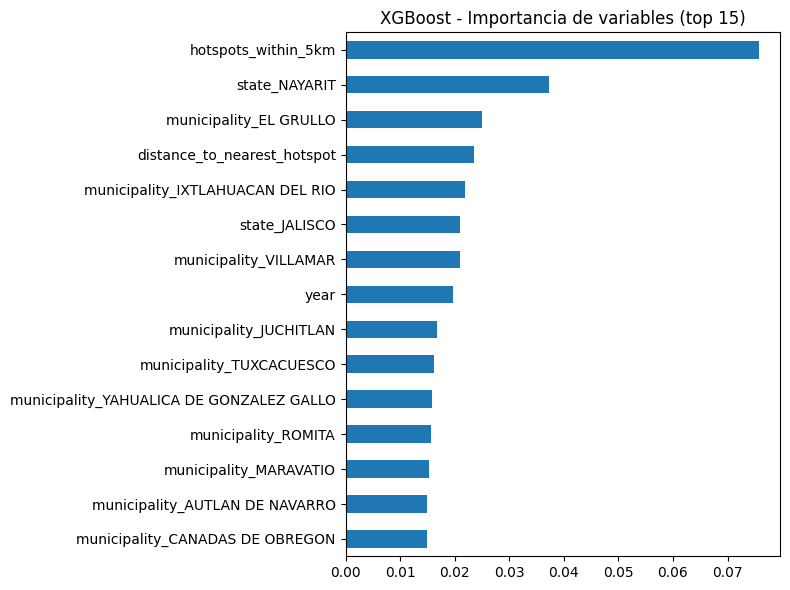

In [ ]:
# =========================================
# Baseline con XGBoost
# - Modelo 1: reg:squarederror (MSE)
# - Modelo 2: count:poisson (para conteos >= 0)
# =========================================

from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# --- split para nuevo estudio
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

def eval_reg(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    return mae, rmse, r2

# ============== Modelo 1: cuadrático estándar ==============
xgb_mse = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

xgb_mse.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    early_stopping_rounds=50,
    verbose=False
)

pred_mse = xgb_mse.predict(X_valid)
mae1, rmse1, r21 = eval_reg(y_valid, pred_mse)

print("🔹 XGBoost (reg:squarederror)")
print(f"MAE  : {mae1:.3f}")
print(f"RMSE : {rmse1:.3f}")
print(f"R²   : {r21:.3f}")
print(f"Best iteration (early stop): {xgb_mse.best_iteration}")

# ============== Modelo 2: Poisson (siempre que y >= 0) ==============
if (y_train.min() >= 0) and (y_valid.min() >= 0):
    xgb_pois = XGBRegressor(
        objective='count:poisson',      # mejor para conteos
        eval_metric='poisson-nloglik',  # métrica de validación
        n_estimators=800,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )

    xgb_pois.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=50,
        verbose=False
    )

    pred_pois = xgb_pois.predict(X_valid)
    mae2, rmse2, r22 = eval_reg(y_valid, pred_pois)

    print("\n🔹 XGBoost (count:poisson)")
    print(f"MAE  : {mae2:.3f}")
    print(f"RMSE : {rmse2:.3f}")
    print(f"R²   : {r22:.3f}")
    print(f"Best n_estimators (early stop): {xgb_pois.best_iteration}")
else:
    print("\n⚠️  Omitido modelo Poisson porque existen valores negativos en y.")

# ============== Importancias de variables (top 15) ==============
model_to_plot = xgb_pois if 'xgb_pois' in locals() else xgb_mse
importances = pd.Series(model_to_plot.feature_importances_, index=X.columns)
top15 = importances.sort_values(ascending=False).head(15)
print("\nTop 15 features:")
print(top15)

plt.figure(figsize=(8,6))
top15.sort_values().plot(kind='barh')
plt.title("XGBoost - Importancia de variables (top 15)")
plt.tight_layout()
plt.show()


Al realizar los estudios con XGBoost y con Random Forest Regressor, encontramos resultados ...............

In [ ]:
# ==============================================
# Bayesian Optimization (Optuna) + Random Forest
# Optuna "Fast Mode" para RandomForestRegressor
# - Muestra opcional de filas
# - Hold-out en objetivo (sin CV)
# - Pruner para cortar trials malos
# - Espacio de búsqueda estrecho
# ==============================================
import optuna

# ---------- Toggles ----------
ROWS_SAMPLE   = 60000      # None para usar todo; pon 60_000 ~ 120_000 según tu máquina
TEST_SIZE_OBJ = 0.2        # hold-out dentro del objetivo
TEST_SIZE_FIN = 0.2        # hold-out final para reporte
N_TRIALS      = 20         # n interacciones
TIMEOUT       = None       # en segundos; p.ej. 900 para 15 min
RANDOM_STATE  = 42

# ---------- Copia y casting a float32 (más rápido/memoria) ----------
X_bo = X.copy()
for c in X_bo.columns:
    if np.issubdtype(X_bo[c].dtype, np.floating):
        X_bo[c] = X_bo[c].astype(np.float32)

y_bo = y.astype(np.float32)

# ---------- Muestreo opcional ----------
if ROWS_SAMPLE is not None and ROWS_SAMPLE < len(X_bo):
    X_bo, _, y_bo, _ = train_test_split(
        X_bo, y_bo, train_size=ROWS_SAMPLE, random_state=RANDOM_STATE
    )

# ---------- Split fijo para el objetivo (repetible y rápido) ----------
Xtr_obj, Xva_obj, ytr_obj, yva_obj = train_test_split(
    X_bo, y_bo, test_size=TEST_SIZE_OBJ, random_state=RANDOM_STATE
)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 250, 320),  # tope moderado
        "max_depth": trial.suggest_categorical("max_depth", [None, 8, 12, 24]),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 12),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 8),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.7, 1.0]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "n_jobs": -1,
        "random_state": RANDOM_STATE,
    }

    # Entrena en hold-out (más rápido que CV)
    model = RandomForestRegressor(**params)
    model.fit(Xtr_obj, ytr_obj)

    pred = model.predict(Xva_obj)
    rmse = mean_squared_error(yva_obj, pred, squared=False)

    # --- Pruning: si va mal, corta temprano comparando con mediana histórica
    trial.report(rmse, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    return rmse

# ---------- Pruner + estudio ----------
pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=N_TRIALS, timeout=TIMEOUT, show_progress_bar=True)

print("\n🏆 Mejores hiperparámetros (fast mode):")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")
print(f"Mejor RMSE (hold-out objetivo): {study.best_value:.4f}")

# ---------- Re-entrenar modelo final con TODO el dataset ----------
best_params = study.best_params.copy()
best_params.update({"n_jobs": -1, "random_state": RANDOM_STATE})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE_FIN, random_state=RANDOM_STATE
)

rf_best = RandomForestRegressor(**best_params)
rf_best.fit(X_train, y_train)
y_pred = rf_best.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2   = r2_score(y_test, y_pred)

print("\n📊 Desempeño final (hold-out):")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")



[I 2025-10-12 12:22:25,274] A new study created in memory with name: no-name-6cdc7626-f273-4f74-b000-de88686735a4
  0%|          | 0/40 [00:00<?, ?it/s]C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 0. Best value: 5.44068:   2%|▎         | 1/40 [00:06<04:02,  6.22s/it]C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 0. Best value: 5.44068:   2%|▎      

[I 2025-10-12 12:22:31,496] Trial 0 finished with value: 5.440681896129188 and parameters: {'n_estimators': 163, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 5.440681896129188.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 0. Best value: 5.44068:   5%|▌         | 2/40 [00:12<04:07,  6.53s/it]

[I 2025-10-12 12:22:38,236] Trial 1 finished with value: 6.026804724156904 and parameters: {'n_estimators': 431, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 5.440681896129188.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 5.41809:   8%|▊         | 3/40 [00:35<08:36, 13.96s/it]

[I 2025-10-12 12:23:01,033] Trial 2 finished with value: 5.418092152147166 and parameters: {'n_estimators': 428, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 5.418092152147166.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 5.41809:  10%|█         | 4/40 [02:49<36:39, 61.10s/it]

[I 2025-10-12 12:25:14,409] Trial 3 finished with value: 6.242019136750203 and parameters: {'n_estimators': 420, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 1.0, 'bootstrap': False}. Best is trial 2 with value: 5.418092152147166.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 5.41809:  12%|█▎        | 5/40 [02:52<23:24, 40.13s/it]

[I 2025-10-12 12:25:17,335] Trial 4 finished with value: 6.2400583980070365 and parameters: {'n_estimators': 237, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 2 with value: 5.418092152147166.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 5.41809:  12%|█▎        | 5/40 [04:06<23:24, 40.13s/it]

[I 2025-10-12 12:26:32,260] Trial 5 finished with value: 5.428018629261081 and parameters: {'n_estimators': 424, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 0.7, 'bootstrap': False}. Best is trial 2 with value: 5.418092152147166.


Best trial: 2. Best value: 5.41809:  15%|█▌        | 6/40 [04:07<29:29, 52.05s/it]C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 5.41809:  18%|█▊        | 7/40 [04:53<27:30, 50.01s/it]C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 5.41809:  18%|█▊        | 7/40 [04:53<27:30, 50.01s/it]

[I 2025-10-12 12:27:18,347] Trial 6 finished with value: 5.937177577824535 and parameters: {'n_estimators': 435, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 0.7, 'bootstrap': False}. Best is trial 2 with value: 5.418092152147166.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 5.41809:  20%|██        | 8/40 [05:06<20:25, 38.31s/it]

[I 2025-10-12 12:27:31,610] Trial 7 finished with value: 5.64354180798053 and parameters: {'n_estimators': 432, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 5.418092152147166.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 8. Best value: 5.39011:  22%|██▎       | 9/40 [06:04<23:03, 44.63s/it]

[I 2025-10-12 12:28:30,144] Trial 8 finished with value: 5.390105688392114 and parameters: {'n_estimators': 450, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 0.7, 'bootstrap': True}. Best is trial 8 with value: 5.390105688392114.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 8. Best value: 5.39011:  25%|██▌       | 10/40 [06:08<16:02, 32.10s/it]

[I 2025-10-12 12:28:34,166] Trial 9 finished with value: 6.452233167988146 and parameters: {'n_estimators': 403, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 8 with value: 5.390105688392114.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 8. Best value: 5.39011:  28%|██▊       | 11/40 [06:46<16:16, 33.68s/it]

[I 2025-10-12 12:29:11,429] Trial 10 finished with value: 5.571740937899856 and parameters: {'n_estimators': 347, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 0.7, 'bootstrap': True}. Best is trial 8 with value: 5.390105688392114.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 11. Best value: 5.29618:  30%|███       | 12/40 [08:03<21:53, 46.91s/it]

[I 2025-10-12 12:30:28,603] Trial 11 finished with value: 5.296177516895531 and parameters: {'n_estimators': 346, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 1.0, 'bootstrap': True}. Best is trial 11 with value: 5.296177516895531.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 11. Best value: 5.29618:  32%|███▎      | 13/40 [09:18<24:56, 55.44s/it]

[I 2025-10-12 12:31:43,677] Trial 12 finished with value: 5.309800043534319 and parameters: {'n_estimators': 339, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 1.0, 'bootstrap': True}. Best is trial 11 with value: 5.296177516895531.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 11. Best value: 5.29618:  35%|███▌      | 14/40 [10:28<25:54, 59.80s/it]

[I 2025-10-12 12:32:53,556] Trial 13 finished with value: 5.332588685074218 and parameters: {'n_estimators': 318, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 1.0, 'bootstrap': True}. Best is trial 11 with value: 5.296177516895531.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  38%|███▊      | 15/40 [11:28<24:58, 59.96s/it]

[I 2025-10-12 12:33:53,869] Trial 14 finished with value: 5.2936339628841145 and parameters: {'n_estimators': 267, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 1.0, 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  40%|████      | 16/40 [12:31<24:20, 60.83s/it]

[I 2025-10-12 12:34:56,738] Trial 15 finished with value: 5.2949035855769795 and parameters: {'n_estimators': 264, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 1.0, 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  42%|████▎     | 17/40 [13:31<23:13, 60.58s/it]

[I 2025-10-12 12:35:56,733] Trial 16 finished with value: 5.294384243237948 and parameters: {'n_estimators': 255, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 1.0, 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  45%|████▌     | 18/40 [14:21<21:00, 57.31s/it]

[I 2025-10-12 12:36:46,442] Trial 17 finished with value: 5.297749662253235 and parameters: {'n_estimators': 210, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 1.0, 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  48%|████▊     | 19/40 [15:29<21:12, 60.60s/it]

[I 2025-10-12 12:37:54,682] Trial 18 finished with value: 5.338080929438805 and parameters: {'n_estimators': 284, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 1.0, 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  50%|█████     | 20/40 [15:59<17:09, 51.46s/it]

[I 2025-10-12 12:38:24,867] Trial 19 finished with value: 5.563836351641918 and parameters: {'n_estimators': 196, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 1.0, 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  52%|█████▎    | 21/40 [16:04<11:51, 37.43s/it]

[I 2025-10-12 12:38:29,590] Trial 20 finished with value: 5.8930953020936165 and parameters: {'n_estimators': 251, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  55%|█████▌    | 22/40 [17:09<13:44, 45.79s/it]

[I 2025-10-12 12:39:34,859] Trial 21 finished with value: 5.296730875796139 and parameters: {'n_estimators': 281, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 1.0, 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  57%|█████▊    | 23/40 [18:09<14:11, 50.09s/it]

[I 2025-10-12 12:40:35,005] Trial 22 finished with value: 5.294447585885783 and parameters: {'n_estimators': 258, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 1.0, 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  60%|██████    | 24/40 [19:01<13:28, 50.55s/it]

[I 2025-10-12 12:41:26,612] Trial 23 finished with value: 5.294547486093766 and parameters: {'n_estimators': 220, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 1.0, 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  62%|██████▎   | 25/40 [20:13<14:17, 57.16s/it]

[I 2025-10-12 12:42:39,206] Trial 24 finished with value: 5.309706717338795 and parameters: {'n_estimators': 304, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 1.0, 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  65%|██████▌   | 26/40 [20:57<12:21, 52.94s/it]

[I 2025-10-12 12:43:22,304] Trial 25 finished with value: 5.3014511312058525 and parameters: {'n_estimators': 184, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 1.0, 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  68%|██████▊   | 27/40 [21:32<10:21, 47.79s/it]

[I 2025-10-12 12:43:58,081] Trial 26 finished with value: 5.5616266092260265 and parameters: {'n_estimators': 236, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 1.0, 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  70%|███████   | 28/40 [22:36<10:32, 52.71s/it]

[I 2025-10-12 12:45:02,257] Trial 27 finished with value: 5.306927375372226 and parameters: {'n_estimators': 272, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 1.0, 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  72%|███████▎  | 29/40 [22:45<07:13, 39.37s/it]

[I 2025-10-12 12:45:10,515] Trial 28 finished with value: 5.716529816448508 and parameters: {'n_estimators': 376, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  75%|███████▌  | 30/40 [22:51<04:55, 29.57s/it]

[I 2025-10-12 12:45:17,221] Trial 29 finished with value: 5.38958106352021 and parameters: {'n_estimators': 154, 'max_depth': None, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  78%|███████▊  | 31/40 [23:31<04:51, 32.43s/it]

[I 2025-10-12 12:45:56,331] Trial 30 finished with value: 5.311658940344467 and parameters: {'n_estimators': 176, 'max_depth': 24, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 1.0, 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  80%|████████  | 32/40 [24:17<04:53, 36.65s/it]

[I 2025-10-12 12:46:42,816] Trial 31 finished with value: 5.294561913106403 and parameters: {'n_estimators': 215, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 1.0, 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  82%|████████▎ | 33/40 [25:03<04:36, 39.52s/it]

[I 2025-10-12 12:47:29,018] Trial 32 finished with value: 5.295106029843808 and parameters: {'n_estimators': 226, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 1.0, 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  85%|████████▌ | 34/40 [25:58<04:23, 43.96s/it]

[I 2025-10-12 12:48:23,357] Trial 33 finished with value: 5.294384243237947 and parameters: {'n_estimators': 255, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 1.0, 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  88%|████████▊ | 35/40 [26:59<04:05, 49.12s/it]

[I 2025-10-12 12:49:24,511] Trial 34 finished with value: 5.308530563821298 and parameters: {'n_estimators': 255, 'max_depth': None, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 1.0, 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  90%|█████████ | 36/40 [27:02<02:21, 35.30s/it]

[I 2025-10-12 12:49:27,568] Trial 35 finished with value: 6.4484150574329115 and parameters: {'n_estimators': 294, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  92%|█████████▎| 37/40 [27:09<01:20, 26.79s/it]

[I 2025-10-12 12:49:34,495] Trial 36 finished with value: 5.531121229375825 and parameters: {'n_estimators': 246, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  95%|█████████▌| 38/40 [28:56<01:41, 50.86s/it]

[I 2025-10-12 12:51:21,526] Trial 37 finished with value: 6.725453284502436 and parameters: {'n_estimators': 310, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 1.0, 'bootstrap': False}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363:  98%|█████████▊| 39/40 [29:34<00:47, 47.22s/it]

[I 2025-10-12 12:52:00,266] Trial 38 finished with value: 5.401241817981914 and parameters: {'n_estimators': 268, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': True}. Best is trial 14 with value: 5.2936339628841145.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 14. Best value: 5.29363: 100%|██████████| 40/40 [29:47<00:00, 44.70s/it]



[I 2025-10-12 12:52:13,221] Trial 39 finished with value: 5.53571630031098 and parameters: {'n_estimators': 324, 'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 14 with value: 5.2936339628841145.

🏆 Mejores hiperparámetros (fast mode):
  n_estimators: 267
  max_depth: 24
  min_samples_split: 4
  min_samples_leaf: 4
  max_features: 1.0
  bootstrap: True
Mejor RMSE (hold-out objetivo): 5.2936

📊 Desempeño final (hold-out):
MAE  : 2.8242
RMSE : 5.2197
R²   : 0.5228

📊 Desempeño final (hold-out):
MAE  : 2.8242
RMSE : 5.2197
R²   : 0.5228


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [33]:
# ============================================================
# Optuna "Fast Mode" para XGBoost (MSE y Poisson) + reporte
# - Muestra opcional de filas
# - Hold-out dentro del objetivo (sin CV) + early stopping
# - Pruner para cortar trials malos
# - Espacio de búsqueda razonable (rápido)
# Requisitos: pip install optuna xgboost
# ============================================================
import numpy as np
import pandas as pd
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ----------------- Toggles -----------------
ROWS_SAMPLE   = 60000   # None para usar todo (puedes bajar/subir)
TEST_SIZE_OBJ = 0.2      # hold-out interno del objetivo (BO)
TEST_SIZE_FIN = 0.2      # hold-out final para reporte
N_TRIALS      = 40       # sube cuando quieras (80–150 si tienes tiempo)
TIMEOUT       = 1200     # p.ej. 900 (15 min)
RANDOM_STATE  = 42
TREE_METHOD   = "gpu_hist"   # "hist" CPU rápido; si tienes GPU: "gpu_hist"
VERBOSE_BOOST = False    # True para ver el training de cada trial
EARLY_STOP    = 50       # early stopping rounds

# ----------------- Copia + casting (memoria/velocidad) -----------------
X_bo = X.copy()
for c in X_bo.columns:
    if np.issubdtype(X_bo[c].dtype, np.floating):
        X_bo[c] = X_bo[c].astype(np.float32)
y_bo = y.astype(np.float32)

# ----------------- Muestreo opcional -----------------
if ROWS_SAMPLE is not None and ROWS_SAMPLE < len(X_bo):
    X_bo, _, y_bo, _ = train_test_split(X_bo, y_bo, train_size=ROWS_SAMPLE, random_state=RANDOM_STATE)

# ----------------- Split fijo para la función objetivo -----------------
Xtr_obj, Xva_obj, ytr_obj, yva_obj = train_test_split(
    X_bo, y_bo, test_size=TEST_SIZE_OBJ, random_state=RANDOM_STATE
)

def make_objective(objective_name: str):
    """Crea una función objetivo de Optuna para XGBRegressor."""
    assert objective_name in {"mse", "poisson"}
    use_poisson = (objective_name == "poisson")

    def objective(trial):
        params = {
            "objective": "count:poisson" if use_poisson else "reg:squarederror",
            "eval_metric": "poisson-nloglik" if use_poisson else "rmse",
            "tree_method": TREE_METHOD,
            "n_estimators": trial.suggest_int("n_estimators", 200, 700),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
            "random_state": RANDOM_STATE,
            "n_jobs": -1,
        }

        model = XGBRegressor(**params)
        model.fit(
            Xtr_obj, ytr_obj,
            eval_set=[(Xva_obj, yva_obj)],
            early_stopping_rounds=EARLY_STOP,
            verbose=VERBOSE_BOOST
        )

        # Usamos RMSE como métrica objetivo (aun en Poisson para comparabilidad)
        pred = model.predict(Xva_obj)
        rmse = mean_squared_error(yva_obj, pred, squared=False)

        trial.report(rmse, step=0)
        if trial.should_prune():
            raise optuna.TrialPruned()

        return rmse

    return objective

def run_bo_for(objective_name: str):
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
    study = optuna.create_study(direction="minimize", pruner=pruner)
    study.optimize(make_objective(objective_name), n_trials=N_TRIALS, timeout=TIMEOUT, show_progress_bar=True)
    return study

# ----------------- Ejecutar BO para MSE -----------------
print("\n================ XGBoost (reg:squarederror) ================")
study_mse = run_bo_for("mse")
print("Mejores hiperparámetros (MSE):")
for k, v in study_mse.best_params.items():
    print(f"  {k}: {v}")
print(f"Mejor RMSE (hold-out objetivo): {study_mse.best_value:.4f}")

# ----------------- Ejecutar BO para Poisson (si procede) -----------------
can_poisson = (y_bo.min() >= 0)
study_pois = None
if can_poisson:
    print("\n================ XGBoost (count:poisson) ================")
    study_pois = run_bo_for("poisson")
    print("Mejores hiperparámetros (Poisson):")
    for k, v in study_pois.best_params.items():
        print(f"  {k}: {v}")
    print(f"Mejor RMSE (hold-out objetivo): {study_pois.best_value:.4f}")
else:
    print("\n  Poisson omitido: existen valores negativos en y.")

# ----------------- Re-entrenar y evaluar en hold-out final -----------------
def evaluate_best(study, label: str):
    best_params = study.best_params.copy()
    best_params.update({
        "objective": "count:poisson" if label == "Poisson" else "reg:squarederror",
        "eval_metric": "poisson-nloglik" if label == "Poisson" else "rmse",
        "tree_method": TREE_METHOD,
        "random_state": RANDOM_STATE,
        "n_jobs": -1
    })

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE_FIN, random_state=RANDOM_STATE
    )

    model = XGBRegressor(**best_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        early_stopping_rounds=EARLY_STOP,
        verbose=VERBOSE_BOOST
    )

    pred = model.predict(X_test)
    mae  = mean_absolute_error(y_test, pred)
    rmse = mean_squared_error(y_test, pred, squared=False)
    r2   = r2_score(y_test, pred)

    print(f"\n📊 Desempeño final ({label})")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")

    # Importancias top-15
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)
    print("\n🔝 Top-15 importancias de variables:")
    print(importances)

# Evaluar ambos (y compara)
evaluate_best(study_mse, "MSE")
if study_pois is not None:
    evaluate_best(study_pois, "Poisson")

[I 2025-10-12 13:44:41,730] A new study created in memory with name: no-name-18f58083-a9f0-4eb5-b6c6-5f57f7a8a92f



================ XGBoost (reg:squarederror) ================


  0%|          | 0/40 [00:00<?, ?it/s]C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:44:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autos

[I 2025-10-12 13:44:48,153] Trial 0 finished with value: 5.743299961090088 and parameters: {'n_estimators': 476, 'learning_rate': 0.12233398084877369, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.7902422712441666, 'colsample_bytree': 0.7385307186696791, 'gamma': 2.36111841583788, 'reg_lambda': 7.515348738140836, 'reg_alpha': 0.0937590113296135}. Best is trial 0 with value: 5.743299961090088.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:44:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:44:51,764] Trial 1 finished with value: 6.039175510406494 and parameters: {'n_estimators': 426, 'learning_rate': 0.02130914154946736, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.7535971320694281, 'colsample_bytree': 0.9912513659950841, 'gamma': 4.0927483190548894, 'reg_lambda': 0.5041791325713908, 'reg_alpha': 0.7770518901073994}. Best is trial 0 with value: 5.743299961090088.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:44:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:44:59,646] Trial 2 finished with value: 5.835315704345703 and parameters: {'n_estimators': 316, 'learning_rate': 0.010243091345293238, 'max_depth': 11, 'min_child_weight': 10, 'subsample': 0.759575934934066, 'colsample_bytree': 0.6414291403566932, 'gamma': 1.7117439773967835, 'reg_lambda': 0.29105150120494533, 'reg_alpha': 0.3055976972935185}. Best is trial 0 with value: 5.743299961090088.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:45:04,451] Trial 3 finished with value: 6.028681755065918 and parameters: {'n_estimators': 646, 'learning_rate': 0.015306651475207718, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.6111555771383611, 'colsample_bytree': 0.7759203442945116, 'gamma': 0.1470727110815595, 'reg_lambda': 1.4375677475183848, 'reg_alpha': 0.5625374755737184}. Best is trial 0 with value: 5.743299961090088.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:45:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:45:07,271] Trial 4 finished with value: 6.117423057556152 and parameters: {'n_estimators': 320, 'learning_rate': 0.03303155658995287, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7547399271486976, 'colsample_bytree': 0.890186506240751, 'gamma': 4.39263740937636, 'reg_lambda': 2.3108269454590227, 'reg_alpha': 0.8566131962776447}. Best is trial 0 with value: 5.743299961090088.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:45:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:45:10,340] Trial 5 finished with value: 5.9226861000061035 and parameters: {'n_estimators': 385, 'learning_rate': 0.19576115409309996, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8824411290673139, 'colsample_bytree': 0.6219565092948864, 'gamma': 4.804653599288888, 'reg_lambda': 0.8045252039318488, 'reg_alpha': 0.3993597549284742}. Best is trial 0 with value: 5.743299961090088.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:45:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:45:15,315] Trial 6 finished with value: 5.767505168914795 and parameters: {'n_estimators': 612, 'learning_rate': 0.07269342555866523, 'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.9540003875018941, 'colsample_bytree': 0.6632313832838772, 'gamma': 1.162390021045316, 'reg_lambda': 0.12436456849516231, 'reg_alpha': 0.06875080254249999}. Best is trial 0 with value: 5.743299961090088.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:45:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:45:19,997] Trial 7 finished with value: 5.743232250213623 and parameters: {'n_estimators': 517, 'learning_rate': 0.08521319605508218, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.9707748540945476, 'colsample_bytree': 0.8194170092188446, 'gamma': 2.9497819231040836, 'reg_lambda': 0.4579553857635881, 'reg_alpha': 0.1990803690758095}. Best is trial 7 with value: 5.743232250213623.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:45:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:45:40,174] Trial 8 finished with value: 5.727691650390625 and parameters: {'n_estimators': 657, 'learning_rate': 0.011089191975215542, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.8213180835765517, 'colsample_bytree': 0.5779943047504201, 'gamma': 2.2453991440000354, 'reg_lambda': 2.350513892825471, 'reg_alpha': 0.06099245579858048}. Best is trial 8 with value: 5.727691650390625.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:45:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:45:43,852] Trial 9 finished with value: 6.336313247680664 and parameters: {'n_estimators': 510, 'learning_rate': 0.012209107237765275, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.5267874968857706, 'colsample_bytree': 0.7493754985694643, 'gamma': 0.6573360430223224, 'reg_lambda': 4.856905770844578, 'reg_alpha': 0.5394662762230612}. Best is trial 8 with value: 5.727691650390625.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:45:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:45:47,906] Trial 10 finished with value: 5.824450492858887 and parameters: {'n_estimators': 212, 'learning_rate': 0.03508712233747638, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.6438294967030647, 'colsample_bytree': 0.5009503544761051, 'gamma': 3.2826524323210315, 'reg_lambda': 2.616663621246488, 'reg_alpha': 0.9847571829197759}. Best is trial 8 with value: 5.727691650390625.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:45:55,196] Trial 11 finished with value: 5.713052749633789 and parameters: {'n_estimators': 697, 'learning_rate': 0.067001979483182, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.9865408404277904, 'colsample_bytree': 0.5167715093149172, 'gamma': 2.959104990988142, 'reg_lambda': 0.325680564481696, 'reg_alpha': 0.19869385135236145}. Best is trial 11 with value: 5.713052749633789.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:45:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:46:04,705] Trial 12 finished with value: 5.720872402191162 and parameters: {'n_estimators': 698, 'learning_rate': 0.04239873211617368, 'max_depth': 12, 'min_child_weight': 3, 'subsample': 0.8668682190206117, 'colsample_bytree': 0.5230542564555709, 'gamma': 2.1774778026812998, 'reg_lambda': 0.17143863557270922, 'reg_alpha': 0.021409479028624723}. Best is trial 11 with value: 5.713052749633789.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:46:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:46:12,871] Trial 13 finished with value: 5.7278876304626465 and parameters: {'n_estimators': 697, 'learning_rate': 0.04093916155596568, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8943400036421885, 'colsample_bytree': 0.5175304869050318, 'gamma': 3.245899939834084, 'reg_lambda': 0.10771658884257919, 'reg_alpha': 0.23527810232635}. Best is trial 11 with value: 5.713052749633789.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:46:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:46:22,652] Trial 14 finished with value: 5.714410305023193 and parameters: {'n_estimators': 586, 'learning_rate': 0.05819162280427034, 'max_depth': 12, 'min_child_weight': 3, 'subsample': 0.9988903688112101, 'colsample_bytree': 0.5531278333336184, 'gamma': 1.6003398108047295, 'reg_lambda': 0.20330956603158817, 'reg_alpha': 0.00044367775603623705}. Best is trial 11 with value: 5.713052749633789.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:46:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:46:27,162] Trial 15 finished with value: 5.731775283813477 and parameters: {'n_estimators': 576, 'learning_rate': 0.14812545362226442, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.9664970671061464, 'colsample_bytree': 0.5840035081545365, 'gamma': 1.3911741482209825, 'reg_lambda': 0.32007968765561046, 'reg_alpha': 0.3922723381229979}. Best is trial 11 with value: 5.713052749633789.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:46:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:46:34,385] Trial 16 finished with value: 5.74225378036499 and parameters: {'n_estimators': 565, 'learning_rate': 0.06707364348201507, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.9890810500892251, 'colsample_bytree': 0.673932032201675, 'gamma': 3.643236870037904, 'reg_lambda': 0.21142156867089554, 'reg_alpha': 0.18905769668574934}. Best is trial 11 with value: 5.713052749633789.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:46:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:46:37,607] Trial 17 finished with value: 5.740405082702637 and parameters: {'n_estimators': 588, 'learning_rate': 0.2642105450932964, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.9178327883933317, 'colsample_bytree': 0.5863811698450201, 'gamma': 1.9173789882564607, 'reg_lambda': 0.7307612450019332, 'reg_alpha': 0.651979942552706}. Best is trial 11 with value: 5.713052749633789.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:46:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:46:47,732] Trial 18 finished with value: 5.749433517456055 and parameters: {'n_estimators': 636, 'learning_rate': 0.02351790254237109, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.6806323326822491, 'colsample_bytree': 0.5587264076634684, 'gamma': 2.809162992543199, 'reg_lambda': 0.20593744683127851, 'reg_alpha': 0.3135081893091939}. Best is trial 11 with value: 5.713052749633789.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:46:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:46:52,259] Trial 19 finished with value: 5.773901462554932 and parameters: {'n_estimators': 538, 'learning_rate': 0.10179654249635488, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.8360816059298593, 'colsample_bytree': 0.6907410388817924, 'gamma': 0.7746643352026206, 'reg_lambda': 0.44272176870691965, 'reg_alpha': 0.14846983467686717}. Best is trial 11 with value: 5.713052749633789.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:46:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:47:00,285] Trial 20 finished with value: 5.673547267913818 and parameters: {'n_estimators': 461, 'learning_rate': 0.06994583972173754, 'max_depth': 11, 'min_child_weight': 2, 'subsample': 0.9299673613835091, 'colsample_bytree': 0.866369076254309, 'gamma': 3.7382102322057076, 'reg_lambda': 1.4294050078613332, 'reg_alpha': 0.003587248370697821}. Best is trial 20 with value: 5.673547267913818.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:47:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:47:09,394] Trial 21 finished with value: 5.727496147155762 and parameters: {'n_estimators': 447, 'learning_rate': 0.06316758160497962, 'max_depth': 11, 'min_child_weight': 2, 'subsample': 0.997520947825389, 'colsample_bytree': 0.9012011376926831, 'gamma': 3.7185479888501902, 'reg_lambda': 1.3234527660384368, 'reg_alpha': 0.12408867004835816}. Best is trial 20 with value: 5.673547267913818.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:47:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:47:20,846] Trial 22 finished with value: 5.703039169311523 and parameters: {'n_estimators': 386, 'learning_rate': 0.051430880496255285, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.9295599558515252, 'colsample_bytree': 0.8596796678903642, 'gamma': 2.8380406750488922, 'reg_lambda': 1.0741518737768097, 'reg_alpha': 0.009968196188203104}. Best is trial 20 with value: 5.673547267913818.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:47:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:47:30,609] Trial 23 finished with value: 5.675893306732178 and parameters: {'n_estimators': 364, 'learning_rate': 0.05069489258063545, 'max_depth': 11, 'min_child_weight': 2, 'subsample': 0.9255599370486569, 'colsample_bytree': 0.8544274830131697, 'gamma': 2.7999352873924583, 'reg_lambda': 1.2490691035878956, 'reg_alpha': 0.00044442150506121547}. Best is trial 20 with value: 5.673547267913818.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:47:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:47:40,324] Trial 24 finished with value: 5.70814323425293 and parameters: {'n_estimators': 366, 'learning_rate': 0.04918973928861413, 'max_depth': 11, 'min_child_weight': 2, 'subsample': 0.9279372827876188, 'colsample_bytree': 0.8735013352604685, 'gamma': 3.8711862328595696, 'reg_lambda': 1.2469770190689564, 'reg_alpha': 0.02581398382504137}. Best is trial 20 with value: 5.673547267913818.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:47:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:47:50,043] Trial 25 finished with value: 5.818059921264648 and parameters: {'n_estimators': 263, 'learning_rate': 0.023544139529589475, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.8446832988820563, 'colsample_bytree': 0.9486855117723989, 'gamma': 2.6872823423768355, 'reg_lambda': 3.562098008474862, 'reg_alpha': 0.26707980189268665}. Best is trial 20 with value: 5.673547267913818.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:47:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:47:57,289] Trial 26 finished with value: 5.691902160644531 and parameters: {'n_estimators': 385, 'learning_rate': 0.09518521848283037, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.9199234793064535, 'colsample_bytree': 0.8339890157736316, 'gamma': 3.3137633487644487, 'reg_lambda': 1.7383707957411292, 'reg_alpha': 0.4227631768016965}. Best is trial 20 with value: 5.673547267913818.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:47:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:48:02,657] Trial 27 finished with value: 5.740161418914795 and parameters: {'n_estimators': 338, 'learning_rate': 0.0927987210788058, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.696749775309492, 'colsample_bytree': 0.8185805716191998, 'gamma': 3.395393170393142, 'reg_lambda': 1.7913515493990955, 'reg_alpha': 0.455152360557756}. Best is trial 20 with value: 5.673547267913818.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:48:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:48:06,947] Trial 28 finished with value: 5.71872091293335 and parameters: {'n_estimators': 417, 'learning_rate': 0.16010897708128993, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9035977103412562, 'colsample_bytree': 0.9333599828728363, 'gamma': 4.326672062137497, 'reg_lambda': 0.796250360024022, 'reg_alpha': 0.7565137568154747}. Best is trial 20 with value: 5.673547267913818.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:48:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:48:13,193] Trial 29 finished with value: 5.719110012054443 and parameters: {'n_estimators': 477, 'learning_rate': 0.12020246238165934, 'max_depth': 11, 'min_child_weight': 3, 'subsample': 0.8053283040433732, 'colsample_bytree': 0.818307710721729, 'gamma': 4.901868530405382, 'reg_lambda': 7.51013662136022, 'reg_alpha': 0.6363984261465859}. Best is trial 20 with value: 5.673547267913818.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:48:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:48:20,600] Trial 30 finished with value: 5.753476619720459 and parameters: {'n_estimators': 471, 'learning_rate': 0.1152370675556486, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.8599608161108542, 'colsample_bytree': 0.777610979077334, 'gamma': 2.5503813587736746, 'reg_lambda': 3.7783616297376654, 'reg_alpha': 0.12796811636379862}. Best is trial 20 with value: 5.673547267913818.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:48:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:48:32,834] Trial 31 finished with value: 5.698478698730469 and parameters: {'n_estimators': 382, 'learning_rate': 0.051441207422007, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.9318529942715577, 'colsample_bytree': 0.8627061543284488, 'gamma': 3.147332617809081, 'reg_lambda': 1.1366131490738798, 'reg_alpha': 0.09091656628572174}. Best is trial 20 with value: 5.673547267913818.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:48:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:48:40,324] Trial 32 finished with value: 5.730197906494141 and parameters: {'n_estimators': 291, 'learning_rate': 0.030423266236605597, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9428230452997609, 'colsample_bytree': 0.8461803076404053, 'gamma': 3.513993526873451, 'reg_lambda': 1.8138379913850318, 'reg_alpha': 0.09935792793979761}. Best is trial 20 with value: 5.673547267913818.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:48:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:48:47,501] Trial 33 finished with value: 5.752974510192871 and parameters: {'n_estimators': 416, 'learning_rate': 0.08030060894376678, 'max_depth': 11, 'min_child_weight': 3, 'subsample': 0.7934666096333542, 'colsample_bytree': 0.9220377419799309, 'gamma': 4.09064122320981, 'reg_lambda': 0.8808607140763881, 'reg_alpha': 0.32377694938722223}. Best is trial 20 with value: 5.673547267913818.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:48:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:48:58,690] Trial 34 finished with value: 5.739701271057129 and parameters: {'n_estimators': 357, 'learning_rate': 0.045868609723814, 'max_depth': 12, 'min_child_weight': 3, 'subsample': 0.8931527967105101, 'colsample_bytree': 0.9855043280245648, 'gamma': 3.286443025395756, 'reg_lambda': 0.631190505759852, 'reg_alpha': 0.05885519189258581}. Best is trial 20 with value: 5.673547267913818.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:48:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:49:09,562] Trial 35 finished with value: 5.707230567932129 and parameters: {'n_estimators': 398, 'learning_rate': 0.028925303380579713, 'max_depth': 11, 'min_child_weight': 2, 'subsample': 0.9335156224167788, 'colsample_bytree': 0.7206353127708425, 'gamma': 3.9424144616868833, 'reg_lambda': 1.6671326946098772, 'reg_alpha': 0.15134686040278567}. Best is trial 20 with value: 5.673547267913818.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:49:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:49:19,702] Trial 36 finished with value: 5.684149742126465 and parameters: {'n_estimators': 453, 'learning_rate': 0.05506531296382014, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8721230956031039, 'colsample_bytree': 0.7822177159604018, 'gamma': 2.4174444006491163, 'reg_lambda': 1.1470375544524594, 'reg_alpha': 0.2586570420107972}. Best is trial 20 with value: 5.673547267913818.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:49:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:49:24,249] Trial 37 finished with value: 5.76344108581543 and parameters: {'n_estimators': 454, 'learning_rate': 0.1454346917738626, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.8748017865161767, 'colsample_bytree': 0.7878727508573414, 'gamma': 2.0315000388905524, 'reg_lambda': 0.6204375548317214, 'reg_alpha': 0.38672843020017794}. Best is trial 20 with value: 5.673547267913818.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:49:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:49:32,880] Trial 38 finished with value: 5.745456695556641 and parameters: {'n_estimators': 490, 'learning_rate': 0.07822027929820963, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.7595772459742504, 'colsample_bytree': 0.7225001245975464, 'gamma': 2.493685598238137, 'reg_lambda': 2.99005257075929, 'reg_alpha': 0.4669433784987381}. Best is trial 20 with value: 5.673547267913818.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:49:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:49:43,041] Trial 39 finished with value: 5.706921100616455 and parameters: {'n_estimators': 440, 'learning_rate': 0.03769038349841355, 'max_depth': 11, 'min_child_weight': 5, 'subsample': 0.9624855490590853, 'colsample_bytree': 0.799978512263535, 'gamma': 4.491508292444458, 'reg_lambda': 2.015893662623344, 'reg_alpha': 0.348748199471223}. Best is trial 20 with value: 5.673547267913818.
Mejores hiperparámetros (MSE):
  n_estimators: 461
  learning_rate: 0.06994583972173754
  max_depth: 11
  min_child_weight: 2
  subsample: 0.9299673613835091
  colsample_bytree: 0.866369076254309
  gamma: 3.7382102322057076
  reg_lambda: 1.4294050078613332
  reg_alpha: 0.003587248370697821
Mejor RMSE (hold-out objetivo): 5.6735

================ XGBoost (count:poisson) ================


  0%|          | 0/40 [00:00<?, ?it/s]C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:49:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Py

[I 2025-10-12 13:49:50,667] Trial 0 finished with value: 5.918701171875 and parameters: {'n_estimators': 694, 'learning_rate': 0.018028019736144558, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.7218436907771019, 'colsample_bytree': 0.9994638606868613, 'gamma': 3.646482308385553, 'reg_lambda': 3.0952589075625587, 'reg_alpha': 0.08887824356680885}. Best is trial 0 with value: 5.918701171875.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:49:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:49:56,134] Trial 1 finished with value: 5.737096309661865 and parameters: {'n_estimators': 488, 'learning_rate': 0.07349408233430484, 'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.8616229418729995, 'colsample_bytree': 0.9715629369382336, 'gamma': 4.472902576940666, 'reg_lambda': 0.12066741937963067, 'reg_alpha': 0.8635880744291022}. Best is trial 1 with value: 5.737096309661865.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:49:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:49:59,046] Trial 2 finished with value: 6.148571968078613 and parameters: {'n_estimators': 200, 'learning_rate': 0.05617267001685923, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.5627730560122128, 'colsample_bytree': 0.896941981814062, 'gamma': 0.6444479689162175, 'reg_lambda': 1.8584679219530427, 'reg_alpha': 0.013269896284114124}. Best is trial 1 with value: 5.737096309661865.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:50:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:50:06,013] Trial 3 finished with value: 5.836359024047852 and parameters: {'n_estimators': 698, 'learning_rate': 0.21302248703970683, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.7019193639657337, 'colsample_bytree': 0.9137064712176877, 'gamma': 0.6930289299097014, 'reg_lambda': 0.14099810253877695, 'reg_alpha': 0.16138385930180876}. Best is trial 1 with value: 5.737096309661865.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:50:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:50:11,073] Trial 4 finished with value: 6.222768306732178 and parameters: {'n_estimators': 614, 'learning_rate': 0.025022211211651456, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.8190590830569039, 'colsample_bytree': 0.9753581095693016, 'gamma': 4.898755700376699, 'reg_lambda': 0.22069624377834202, 'reg_alpha': 0.9272529848055167}. Best is trial 1 with value: 5.737096309661865.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:50:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:50:14,771] Trial 5 finished with value: 5.793949604034424 and parameters: {'n_estimators': 370, 'learning_rate': 0.29812752755775385, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.9474914421845784, 'colsample_bytree': 0.7988935588531043, 'gamma': 3.3491383011529456, 'reg_lambda': 0.4319091554969427, 'reg_alpha': 0.5466371844732006}. Best is trial 1 with value: 5.737096309661865.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:50:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:50:20,173] Trial 6 finished with value: 5.889599323272705 and parameters: {'n_estimators': 669, 'learning_rate': 0.057479732247996206, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.6453283432935562, 'colsample_bytree': 0.8209249917232595, 'gamma': 0.7854665493926333, 'reg_lambda': 0.12575364810057083, 'reg_alpha': 0.4471594939503808}. Best is trial 1 with value: 5.737096309661865.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:50:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:50:25,534] Trial 7 finished with value: 5.979035377502441 and parameters: {'n_estimators': 559, 'learning_rate': 0.25439793712882464, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.5800772802467569, 'colsample_bytree': 0.9332699741213164, 'gamma': 2.2404278603217382, 'reg_lambda': 0.19451750633040973, 'reg_alpha': 0.3859198809888442}. Best is trial 1 with value: 5.737096309661865.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:50:31,664] Trial 8 finished with value: 5.667970657348633 and parameters: {'n_estimators': 500, 'learning_rate': 0.0937766699236795, 'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.7770028648003535, 'colsample_bytree': 0.8672252860580307, 'gamma': 3.6959288456170336, 'reg_lambda': 8.368718317234972, 'reg_alpha': 0.010951252630997499}. Best is trial 8 with value: 5.667970657348633.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:50:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:50:36,938] Trial 9 finished with value: 5.688316822052002 and parameters: {'n_estimators': 280, 'learning_rate': 0.18688216240666286, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.7851476526972891, 'colsample_bytree': 0.989205817657259, 'gamma': 2.3145469390474593, 'reg_lambda': 5.249450944197433, 'reg_alpha': 0.34316350995870903}. Best is trial 8 with value: 5.667970657348633.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:50:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:50:43,380] Trial 10 finished with value: 5.732343673706055 and parameters: {'n_estimators': 415, 'learning_rate': 0.11365597139304554, 'max_depth': 12, 'min_child_weight': 4, 'subsample': 0.9075377854870132, 'colsample_bytree': 0.63842996839249, 'gamma': 3.47987692961142, 'reg_lambda': 9.945159505872928, 'reg_alpha': 0.6732691032903095}. Best is trial 8 with value: 5.667970657348633.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:50:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:50:49,369] Trial 11 finished with value: 5.735699653625488 and parameters: {'n_estimators': 282, 'learning_rate': 0.127770485088609, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.7921972616457769, 'colsample_bytree': 0.6987173703663357, 'gamma': 2.02927440327187, 'reg_lambda': 7.232440272771587, 'reg_alpha': 0.26030562622033715}. Best is trial 8 with value: 5.667970657348633.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:50:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:50:57,547] Trial 12 finished with value: 5.731018543243408 and parameters: {'n_estimators': 506, 'learning_rate': 0.11836662893039777, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.7652601820551709, 'colsample_bytree': 0.8340693552179164, 'gamma': 1.60841745365655, 'reg_lambda': 3.635621739093285, 'reg_alpha': 0.26184206847499103}. Best is trial 8 with value: 5.667970657348633.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:50:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:51:04,231] Trial 13 finished with value: 5.802966594696045 and parameters: {'n_estimators': 332, 'learning_rate': 0.034098572411923544, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.8618218925454864, 'colsample_bytree': 0.5512240415593781, 'gamma': 2.8303065626577233, 'reg_lambda': 1.3176126257542198, 'reg_alpha': 0.67880393941515}. Best is trial 8 with value: 5.667970657348633.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:51:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:51:08,695] Trial 14 finished with value: 5.801385402679443 and parameters: {'n_estimators': 209, 'learning_rate': 0.1677585221984513, 'max_depth': 11, 'min_child_weight': 6, 'subsample': 0.9975884557485863, 'colsample_bytree': 0.8681765805942001, 'gamma': 4.035086055313001, 'reg_lambda': 5.365182948587111, 'reg_alpha': 0.2879126302894839}. Best is trial 8 with value: 5.667970657348633.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:51:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:51:16,356] Trial 15 finished with value: 5.966587066650391 and parameters: {'n_estimators': 437, 'learning_rate': 0.011799428161185245, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.6674440255128946, 'colsample_bytree': 0.7530999951865295, 'gamma': 2.8160684536171523, 'reg_lambda': 0.4845596857968494, 'reg_alpha': 0.14886972850259417}. Best is trial 8 with value: 5.667970657348633.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:51:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:51:21,065] Trial 16 finished with value: 5.870026111602783 and parameters: {'n_estimators': 282, 'learning_rate': 0.08441997398428426, 'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.5034861847884355, 'colsample_bytree': 0.8676257200297368, 'gamma': 1.5040952496205366, 'reg_lambda': 2.651958878922834, 'reg_alpha': 0.5478679462177934}. Best is trial 8 with value: 5.667970657348633.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:51:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:51:30,008] Trial 17 finished with value: 5.738346576690674 and parameters: {'n_estimators': 547, 'learning_rate': 0.0390614730885974, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.8226283635267975, 'colsample_bytree': 0.7446826171637815, 'gamma': 2.757621909849007, 'reg_lambda': 5.673681811848801, 'reg_alpha': 0.012137535621605022}. Best is trial 8 with value: 5.667970657348633.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:51:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:51:34,829] Trial 18 finished with value: 5.784473896026611 and parameters: {'n_estimators': 402, 'learning_rate': 0.18103490667201763, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.7536770445024943, 'colsample_bytree': 0.9364868295378186, 'gamma': 3.978963937679773, 'reg_lambda': 0.8665844013342416, 'reg_alpha': 0.39597232346436456}. Best is trial 8 with value: 5.667970657348633.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:51:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:51:41,854] Trial 19 finished with value: 5.770970344543457 and parameters: {'n_estimators': 479, 'learning_rate': 0.08704958813883212, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.6421190288621601, 'colsample_bytree': 0.7709038560341352, 'gamma': 1.5369900734169009, 'reg_lambda': 9.344288770169126, 'reg_alpha': 0.7773881239116219}. Best is trial 8 with value: 5.667970657348633.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:51:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:51:47,078] Trial 20 finished with value: 5.853593349456787 and parameters: {'n_estimators': 321, 'learning_rate': 0.14245697470225044, 'max_depth': 11, 'min_child_weight': 4, 'subsample': 0.8892588455168571, 'colsample_bytree': 0.6446339852439104, 'gamma': 3.12777799426365, 'reg_lambda': 4.773014360850496, 'reg_alpha': 0.18291197520948668}. Best is trial 8 with value: 5.667970657348633.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:51:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:51:57,006] Trial 21 finished with value: 5.6884260177612305 and parameters: {'n_estimators': 539, 'learning_rate': 0.1062841410478097, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.7565034837324225, 'colsample_bytree': 0.8397115784215345, 'gamma': 0.05149680797007239, 'reg_lambda': 3.3822318772463364, 'reg_alpha': 0.33044037782595653}. Best is trial 8 with value: 5.667970657348633.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:51:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:52:09,227] Trial 22 finished with value: 5.816313743591309 and parameters: {'n_estimators': 574, 'learning_rate': 0.09560772883225921, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.7117910398434366, 'colsample_bytree': 0.8634033495903227, 'gamma': 0.17152768117573958, 'reg_lambda': 2.1758547188547914, 'reg_alpha': 0.31106703288750737}. Best is trial 8 with value: 5.667970657348633.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:52:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:52:17,641] Trial 23 finished with value: 5.749004364013672 and parameters: {'n_estimators': 609, 'learning_rate': 0.17641494665745686, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.7857247357859976, 'colsample_bytree': 0.9425430026254212, 'gamma': 2.261137937154134, 'reg_lambda': 4.9243916034587505, 'reg_alpha': 0.3747147855818515}. Best is trial 8 with value: 5.667970657348633.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:52:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:52:29,663] Trial 24 finished with value: 5.6934709548950195 and parameters: {'n_estimators': 514, 'learning_rate': 0.07426129797451947, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.8286948460299595, 'colsample_bytree': 0.6958102981384754, 'gamma': 0.17916400043705893, 'reg_lambda': 1.5298303294934235, 'reg_alpha': 0.5028849988271004}. Best is trial 8 with value: 5.667970657348633.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:52:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:52:36,064] Trial 25 finished with value: 5.821935653686523 and parameters: {'n_estimators': 468, 'learning_rate': 0.049780112963418645, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.7311970518576144, 'colsample_bytree': 0.8892736179213442, 'gamma': 4.975320236094412, 'reg_lambda': 3.811920146976049, 'reg_alpha': 0.6173250500649665}. Best is trial 8 with value: 5.667970657348633.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:52:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:52:42,073] Trial 26 finished with value: 5.617076873779297 and parameters: {'n_estimators': 621, 'learning_rate': 0.22308566883906356, 'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.6823606274424366, 'colsample_bytree': 0.8242354868088557, 'gamma': 4.29868617291535, 'reg_lambda': 6.685274304474293, 'reg_alpha': 0.09897719677003664}. Best is trial 26 with value: 5.617076873779297.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:52:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:52:48,719] Trial 27 finished with value: 5.752265930175781 and parameters: {'n_estimators': 633, 'learning_rate': 0.22229246533466315, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.6787438155794562, 'colsample_bytree': 0.7936642963333156, 'gamma': 4.359691591875793, 'reg_lambda': 7.129389607447758, 'reg_alpha': 0.07264785889117639}. Best is trial 26 with value: 5.617076873779297.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:52:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:52:55,178] Trial 28 finished with value: 5.895087242126465 and parameters: {'n_estimators': 374, 'learning_rate': 0.15155809247523208, 'max_depth': 11, 'min_child_weight': 9, 'subsample': 0.6064656729797399, 'colsample_bytree': 0.9688348901381217, 'gamma': 3.9274423723964547, 'reg_lambda': 7.319072111313852, 'reg_alpha': 0.20504794179658314}. Best is trial 26 with value: 5.617076873779297.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:52:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:53:02,253] Trial 29 finished with value: 5.862675189971924 and parameters: {'n_estimators': 660, 'learning_rate': 0.2366381238688662, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.7085217926097532, 'colsample_bytree': 0.7071237088720337, 'gamma': 4.545230718541633, 'reg_lambda': 2.6268445183349303, 'reg_alpha': 0.061823909182265435}. Best is trial 26 with value: 5.617076873779297.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:53:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:53:08,451] Trial 30 finished with value: 5.9436798095703125 and parameters: {'n_estimators': 584, 'learning_rate': 0.2705553246508527, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.7775868640005187, 'colsample_bytree': 0.9844527375492808, 'gamma': 3.8133756461319117, 'reg_lambda': 9.614976937242863, 'reg_alpha': 0.08973715725392632}. Best is trial 26 with value: 5.617076873779297.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:53:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:53:15,548] Trial 31 finished with value: 5.709510803222656 and parameters: {'n_estimators': 540, 'learning_rate': 0.1139432758850067, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.7396727103228794, 'colsample_bytree': 0.8373406512104355, 'gamma': 3.2876590671303534, 'reg_lambda': 3.541598752966227, 'reg_alpha': 0.10784052283126401}. Best is trial 26 with value: 5.617076873779297.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:53:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:53:21,609] Trial 32 finished with value: 5.736571311950684 and parameters: {'n_estimators': 526, 'learning_rate': 0.18490658159179296, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.8055723125247525, 'colsample_bytree': 0.8094687968857128, 'gamma': 3.6382829627009396, 'reg_lambda': 6.276965855882937, 'reg_alpha': 0.22513879225200778}. Best is trial 26 with value: 5.617076873779297.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:53:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:53:29,670] Trial 33 finished with value: 5.6923370361328125 and parameters: {'n_estimators': 449, 'learning_rate': 0.09717779521823139, 'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.8425026904760121, 'colsample_bytree': 0.839871370933452, 'gamma': 1.0787106011850525, 'reg_lambda': 4.2431944970459945, 'reg_alpha': 0.33060536989225187}. Best is trial 26 with value: 5.617076873779297.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:53:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:53:36,847] Trial 34 finished with value: 5.724354267120361 and parameters: {'n_estimators': 601, 'learning_rate': 0.06312886540709023, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.6981531003441599, 'colsample_bytree': 0.9069792495115125, 'gamma': 4.261941242223857, 'reg_lambda': 2.773333961172458, 'reg_alpha': 0.005070132067266748}. Best is trial 26 with value: 5.617076873779297.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:53:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:53:43,394] Trial 35 finished with value: 5.731263637542725 and parameters: {'n_estimators': 644, 'learning_rate': 0.14360366643166583, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.7498449840202799, 'colsample_bytree': 0.8848880773583611, 'gamma': 4.746617837196631, 'reg_lambda': 0.9326552622185065, 'reg_alpha': 0.12103581005126263}. Best is trial 26 with value: 5.617076873779297.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:53:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:53:48,806] Trial 36 finished with value: 5.555356979370117 and parameters: {'n_estimators': 504, 'learning_rate': 0.21131404574168527, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.6262722697191789, 'colsample_bytree': 0.779033721482664, 'gamma': 1.2194583687724512, 'reg_lambda': 7.53629566653249, 'reg_alpha': 0.4672044945803927}. Best is trial 36 with value: 5.555356979370117.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:53:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:53:54,192] Trial 37 finished with value: 5.705254077911377 and parameters: {'n_estimators': 495, 'learning_rate': 0.19328740825852936, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.615409791931271, 'colsample_bytree': 0.776324082247532, 'gamma': 1.890807870541813, 'reg_lambda': 7.590009446884352, 'reg_alpha': 0.4490214123647031}. Best is trial 36 with value: 5.555356979370117.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:53:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:53:57,956] Trial 38 finished with value: 5.876049995422363 and parameters: {'n_estimators': 248, 'learning_rate': 0.2981229176811454, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.5099308863001508, 'colsample_bytree': 0.7264314122707303, 'gamma': 1.22479869134201, 'reg_lambda': 5.919450678442783, 'reg_alpha': 0.9885827482927105}. Best is trial 36 with value: 5.555356979370117.


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:53:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

[I 2025-10-12 13:54:04,568] Trial 39 finished with value: 7.196204662322998 and parameters: {'n_estimators': 695, 'learning_rate': 0.23061806055051476, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.5655809161474431, 'colsample_bytree': 0.994282951801993, 'gamma': 2.5591731345400786, 'reg_lambda': 0.6619208962916784, 'reg_alpha': 0.44480709605796087}. Best is trial 36 with value: 5.555356979370117.
Mejores hiperparámetros (Poisson):
  n_estimators: 504
  learning_rate: 0.21131404574168527
  max_depth: 5
  min_child_weight: 10
  subsample: 0.6262722697191789
  colsample_bytree: 0.779033721482664
  gamma: 1.2194583687724512
  reg_lambda: 7.53629566653249
  reg_alpha: 0.4672044945803927
Mejor RMSE (hold-out objetivo): 5.5554


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:54:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc


📊 Desempeño final (MSE)
MAE  : 2.8236
RMSE : 5.2836
R²   : 0.5110

🔝 Top-15 importancias de variables:
municipality_MARAVATIO                  0.082161
municipality_VILLAMAR                   0.031504
municipality_CANADAS DE OBREGON         0.030098
municipality_IXTLAHUACAN DEL RIO        0.026705
municipality_AMATITAN                   0.023942
municipality_ROMITA                     0.016395
municipality_CUQUIO                     0.016302
state_MICHOACAN                         0.015432
municipality_COCULA                     0.015183
hotspots_within_5km                     0.014170
distance_to_nearest_hotspot             0.014069
municipality_SAN JUANITO DE ESCOBEDO    0.012965
municipality_TONAYA                     0.012400
municipality_TECOLOTLAN                 0.011877
municipality_SAN IGNACIO CERRO GORDO    0.011864
dtype: float32


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:54:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc


📊 Desempeño final (Poisson)
MAE  : 3.0326
RMSE : 5.5299
R²   : 0.4644

🔝 Top-15 importancias de variables:
municipality_MARAVATIO              0.026848
municipality_IXTLAHUACAN DEL RIO    0.025962
distance_to_nearest_hotspot         0.025757
municipality_CUQUIO                 0.022296
municipality_VILLAMAR               0.021087
municipality_CANADAS DE OBREGON     0.019014
municipality_JUCHITLAN              0.018355
year                                0.018309
municipality_ROMITA                 0.017370
lat                                 0.016175
municipality_ATENGO                 0.016095
municipality_COCULA                 0.014864
municipality_TUXPAN                 0.012987
plantation_age                      0.012203
lon                                 0.012077
dtype: float32


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
